# Intel Image Classification using CNNs

## Assignment 4: Multi-class Classification with PyTorch

This notebook implements a multi-class classification problem on the Intel Image Classification Dataset, which contains natural scene images across six categories (buildings, forest, glacier, mountain, sea, street).

## 1. Setup and Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm  # Auto-chooses between notebook and CLI
import random
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## 2. Download and Load the Dataset from Kaggle

The Intel Image Classification dataset is available on Kaggle. To download it, we need to use the Kaggle API.

In [3]:
# # Install the Kaggle API if not already installed
# !pip install -q kaggle

# # Create Kaggle directory if it doesn't exist
# !mkdir -p ~/.kaggle

# # Create a new API token from Kaggle (https://www.kaggle.com/account) and upload it here
# # Note: You need to create a Kaggle account if you don't have one
# # After generating the token, upload the kaggle.json file

In [4]:
# # Upload your kaggle.json file here or set API credentials manually
# # from google.colab import files
# # uploaded = files.upload()

# # Move the kaggle.json file to the right location
# # !cp kaggle.json ~/.kaggle/
# # !chmod 600 ~/.kaggle/kaggle.json

# # Download the Intel Image Classification dataset
# !kaggle datasets download -d puneet6060/intel-image-classification
# !unzip -q intel-image-classification.zip

## 3. Explore the Dataset

In [5]:
# Data directories
data_dir = 'seg_train/seg_train/'
test_dir = 'seg_test/seg_test/'
pred_dir = 'seg_pred/seg_pred/'

# Check the structure of the dataset
!ls -la {data_dir}

# List classes
classes = os.listdir(data_dir)
print(f"Classes: {classes}")

# Count samples per class
class_counts = {}
for cls in classes:
    class_counts[cls] = len(os.listdir(os.path.join(data_dir, cls)))
    
print("\nSample counts per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

total 460
drwxrwxr-x 8 shinobi-owl shinobi-owl  4096 May  3 10:38 .
drwxrwxr-x 3 shinobi-owl shinobi-owl  4096 May  3 10:38 ..
drwxrwxr-x 2 shinobi-owl shinobi-owl 69632 May  3 10:38 buildings
drwxrwxr-x 2 shinobi-owl shinobi-owl 69632 May  3 10:38 forest
drwxrwxr-x 2 shinobi-owl shinobi-owl 77824 May  3 10:38 glacier
drwxrwxr-x 2 shinobi-owl shinobi-owl 86016 May  3 10:38 mountain
drwxrwxr-x 2 shinobi-owl shinobi-owl 77824 May  3 10:38 sea
drwxrwxr-x 2 shinobi-owl shinobi-owl 77824 May  3 10:38 street
Classes: ['glacier', 'sea', 'forest', 'mountain', 'buildings', 'street']

Sample counts per class:
glacier: 2404
sea: 2274
forest: 2271
mountain: 2512
buildings: 2191
street: 2382


### Visualize Sample Images

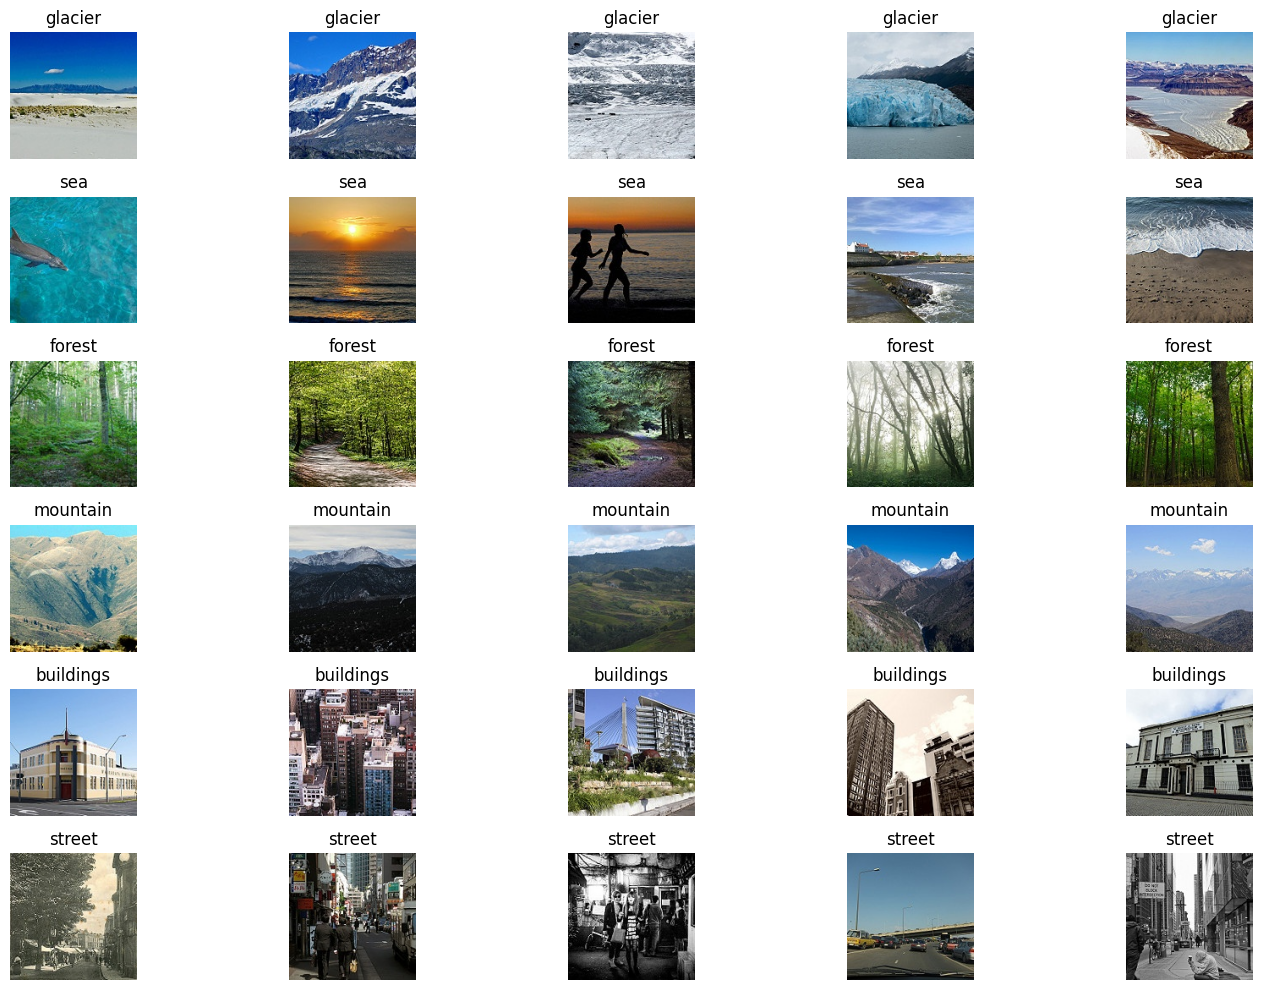

In [6]:
import matplotlib.image as mpimg

plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    images = os.listdir(class_path)[:5]  # Get first 5 images from each class
    
    for j, img_name in enumerate(images):
        plt.subplot(len(classes), 5, i*5 + j + 1)
        img = mpimg.imread(os.path.join(class_path, img_name))
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
        
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Define data transforms and create data loaders.

In [7]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),  # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Data augmentation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageFolder(root=data_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# Split training data into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 11227
Validation set size: 2807
Test set size: 3000


## 5. Model Definitions

### 5.1 Lightweight CNN Model (~500K parameters)

In [9]:
class LightweightCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(LightweightCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 64 x 64 x 64
 
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 128 x 32 x 32
 
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # Output: 128 x 1 x 1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 1024),  # 128 → 1024
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
 
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create a lightweight model and count parameters
lightweight_model = LightweightCNN().to(device)
total_params = sum(p.numel() for p in lightweight_model.parameters())
print(f"Lightweight CNN total parameters: {total_params:,}")
print(lightweight_model)

Lightweight CNN total parameters: 526,662
LightweightCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): AdaptiveAvgPool2d(output_size=1)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6, bias=True)
  )
)


### 5.2 Deeper CNN Model (~10M parameters)

We'll create a modified version of ResNet-18 with more filters to reach approximately 10M parameters.

In [10]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Load ResNet-18 model without pre-trained weights
deeper_model = models.resnet18(weights=None) # Use weights=None for no pretraining

# Modify the final fully connected layer for the required number of classes (6)
num_ftrs = deeper_model.fc.in_features
num_classes = 6 # As used in previous models
deeper_model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the specified device
deeper_model = deeper_model.to(device)

# Calculate and print the total number of parameters
total_params = sum(p.numel() for p in deeper_model.parameters() if p.requires_grad)
print(f"ResNet-18 based model total parameters: {total_params:,}")
print(deeper_model)

# Note: Standard ResNet-18 has ~11.7M parameters. This is close to the 10M target.
# If a precise 10M is needed, further modifications like reducing layer widths would be required,
# but ResNet-18 serves as a good starting point for a ~10M parameter model.


ResNet-18 based model total parameters: 11,179,590
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

## 6. Training and Evaluation Functions

In [11]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, scheduler=None):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        # Step the scheduler if it exists
        if scheduler is not None:
            # For ReduceLROnPlateau scheduler which monitors validation loss
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()
        
        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved model with validation accuracy: {best_val_acc:.4f}")
    
    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_loss / len(data_loader.dataset)
    test_acc = correct / total
    
    return test_loss, test_acc, all_preds, all_labels

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(15, 5))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    
    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

## 7. Experiment 1: Lightweight CNN with Batch Normalization + Adam

Epoch 1/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 1.2479, Train Acc: 0.4513 - Val Loss: 1.0129, Val Acc: 0.5454
Saved model with validation accuracy: 0.5454


Epoch 2/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.9922, Train Acc: 0.5621 - Val Loss: 0.8985, Val Acc: 0.6167
Saved model with validation accuracy: 0.6167


Epoch 3/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 3/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
 
 Traceback (most recent call last):
   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()  
    File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/t

Epoch 3/15 - Train Loss: 0.8360, Train Acc: 0.6571 - Val Loss: 0.7294, Val Acc: 0.7186
Saved model with validation accuracy: 0.7186


Epoch 4/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 4/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0> 
 Traceback (most recent call last):
   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers()
   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/py

Epoch 4/15 - Train Loss: 0.6809, Train Acc: 0.7396 - Val Loss: 0.6574, Val Acc: 0.7517
Saved model with validation accuracy: 0.7517


Epoch 5/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
Exception ignored in:   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    if w.is_alive():    
self._shutdown_workers() 
   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive(): 
^ ^ ^ ^  ^^ ^^ ^^^^^^
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/pro

Epoch 5/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.6068, Train Acc: 0.7694 - Val Loss: 0.5398, Val Acc: 0.8019
Saved model with validation accuracy: 0.8019


Epoch 6/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 6/15 - Train Loss: 0.5527, Train Acc: 0.7913 - Val Loss: 0.4863, Val Acc: 0.8187
Saved model with validation accuracy: 0.8187


Epoch 7/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>

Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()

   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
    ^^ ^ ^ ^ ^ ^^^^^^^^^^^
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/

Epoch 7/15 - Train Loss: 0.4957, Train Acc: 0.8172 - Val Loss: 0.5127, Val Acc: 0.8147


Epoch 8/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.4774, Train Acc: 0.8234 - Val Loss: 0.4641, Val Acc: 0.8351
Saved model with validation accuracy: 0.8351


Epoch 9/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 9/15 - Train Loss: 0.4357, Train Acc: 0.8436 - Val Loss: 0.4417, Val Acc: 0.8429
Saved model with validation accuracy: 0.8429


Epoch 10/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.4241, Train Acc: 0.8472 - Val Loss: 0.4926, Val Acc: 0.8279


Epoch 11/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 11/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>^^
^Traceback (most recent call last):
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^^  File "/home/shinobi-owl/ana

Epoch 11/15 - Train Loss: 0.4020, Train Acc: 0.8538 - Val Loss: 0.4033, Val Acc: 0.8571
Saved model with validation accuracy: 0.8571


Epoch 12/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 12/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>^
Traceback (most recent call last):
^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
AssertionError:     can only test a child process

Epoch 12/15 - Train Loss: 0.3897, Train Acc: 0.8586 - Val Loss: 0.4185, Val Acc: 0.8571


Epoch 13/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.3686, Train Acc: 0.8661 - Val Loss: 0.4476, Val Acc: 0.8457


Epoch 14/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.3704, Train Acc: 0.8667 - Val Loss: 0.3741, Val Acc: 0.8660
Saved model with validation accuracy: 0.8660


Epoch 15/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.3487, Train Acc: 0.8727 - Val Loss: 0.3634, Val Acc: 0.8668
Saved model with validation accuracy: 0.8668


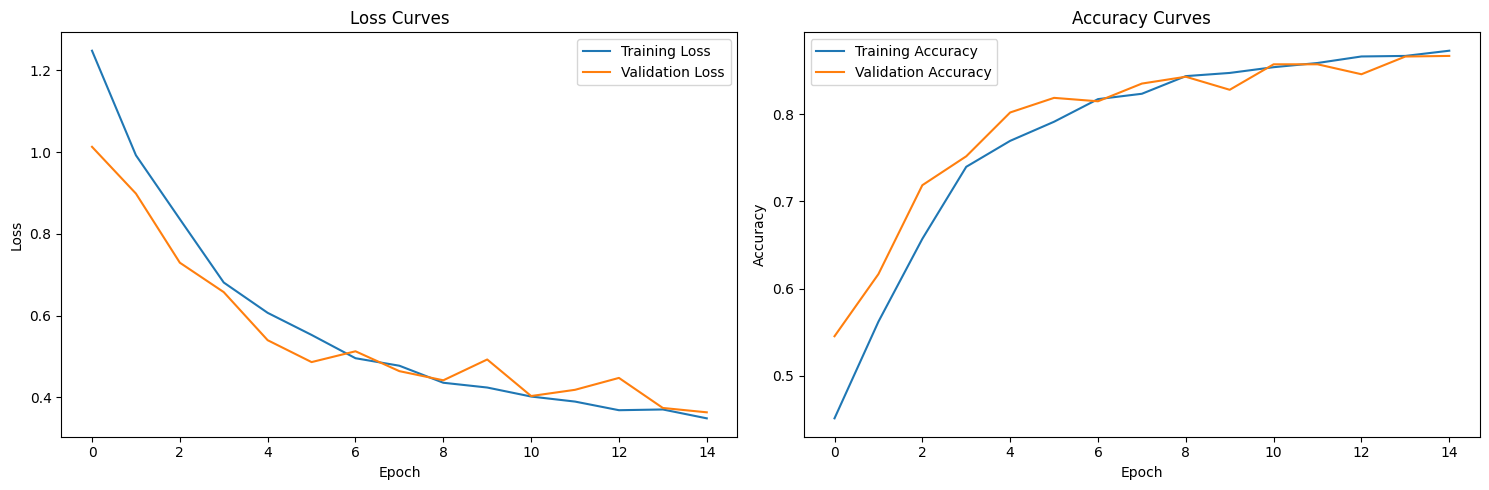

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Test Loss: 0.4090, Test Accuracy: 0.8543


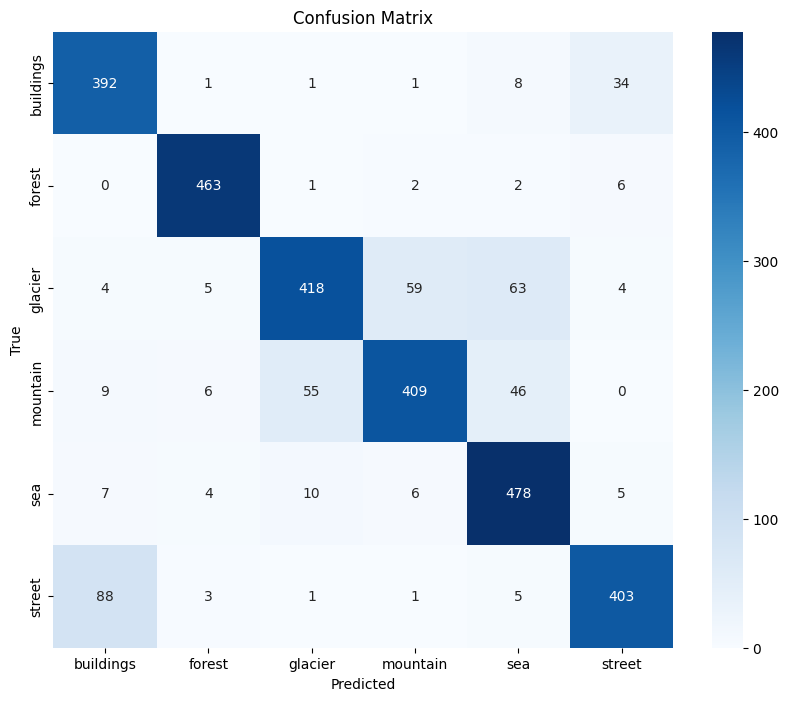

Classification Report:
              precision    recall  f1-score   support

   buildings       0.78      0.90      0.84       437
      forest       0.96      0.98      0.97       474
     glacier       0.86      0.76      0.80       553
    mountain       0.86      0.78      0.82       525
         sea       0.79      0.94      0.86       510
      street       0.89      0.80      0.85       501

    accuracy                           0.85      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.85      0.85      3000



In [13]:
# Define hyperparameters
num_epochs = 15
learning_rate = 1e-3

# Create model
lightweight_model1 = LightweightCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lightweight_model1.parameters(), lr=learning_rate)

# Train model
lightweight_model1, train_losses1, val_losses1, train_accs1, val_accs1 = train_model(
    lightweight_model1, train_loader, val_loader, optimizer, criterion, num_epochs=num_epochs
)

# Plot training curves
plot_training_curves(train_losses1, val_losses1, train_accs1, val_accs1)

# Evaluate on test set
test_loss1, test_acc1, all_preds1, all_labels1 = evaluate_model(lightweight_model1, test_loader, criterion)
print(f"Test Loss: {test_loss1:.4f}, Test Accuracy: {test_acc1:.4f}")

# Plot confusion matrix
class_names = list(train_dataset.dataset.class_to_idx.keys())
plot_confusion_matrix(all_labels1, all_preds1, class_names)

## 8. Experiment 2: Lightweight CNN with Group Normalization + SGD

Epoch 1/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 1/15 - Train Loss: 1.7894, Train Acc: 0.1816 - Val Loss: 1.7873, Val Acc: 0.1685
Saved model with validation accuracy: 0.1685


Epoch 2/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0> 
  Traceback (most recent call last):
   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      ^self._shutdown_workers()^^
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^^    ^if w.is_alive():^^
^ ^ 
   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py

Epoch 2/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

 ^ ^ ^ ^^^^^^^^^^^
^^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^^ ^^ ^ ^^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^
^AssertionError^: ^can only test a child process^
^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 2/15 - Train Loss: 1.7605, Train Acc: 0.2551 - Val Loss: 1.6593, Val Acc: 0.3196
Saved model with validation accuracy: 0.3196


Epoch 3/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 1.4690, Train Acc: 0.3883 - Val Loss: 1.3292, Val Acc: 0.4289
Saved model with validation accuracy: 0.4289


Epoch 4/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>

 Traceback (most recent call last):
   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers() 
   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python

Epoch 4/15 - Train Loss: 1.3084, Train Acc: 0.4488 - Val Loss: 1.2410, Val Acc: 0.4731
Saved model with validation accuracy: 0.4731


Epoch 5/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 1.2186, Train Acc: 0.4832 - Val Loss: 1.1655, Val Acc: 0.5255
Saved model with validation accuracy: 0.5255


Epoch 6/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 6/15 - Train Loss: 1.1607, Train Acc: 0.5113 - Val Loss: 1.1324, Val Acc: 0.5258
Saved model with validation accuracy: 0.5258


Epoch 7/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 1.1231, Train Acc: 0.5303 - Val Loss: 1.1201, Val Acc: 0.5369
Saved model with validation accuracy: 0.5369


Epoch 8/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 8/15 - Train Loss: 1.1006, Train Acc: 0.5488 - Val Loss: 1.0961, Val Acc: 0.5315


Epoch 9/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 9/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>^
^Traceback (most recent call last):
^^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/home/shinobi-owl/anaconda3/envs/

Epoch 9/15 - Train Loss: 1.0798, Train Acc: 0.5538 - Val Loss: 1.0531, Val Acc: 0.5622
Saved model with validation accuracy: 0.5622


Epoch 10/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>^
^Traceback (most recent call last):
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^^    ^self._shutdown_workers()^
^  File "/home/shinobi-owl/anaconda3/envs/se

Epoch 10/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 1.0547, Train Acc: 0.5681 - Val Loss: 1.0373, Val Acc: 0.5714
Saved model with validation accuracy: 0.5714


Epoch 11/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 1.0450, Train Acc: 0.5634 - Val Loss: 1.0227, Val Acc: 0.5753
Saved model with validation accuracy: 0.5753


Epoch 12/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 1.0217, Train Acc: 0.5836 - Val Loss: 1.0102, Val Acc: 0.5800
Saved model with validation accuracy: 0.5800


Epoch 13/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.9978, Train Acc: 0.5937 - Val Loss: 0.9887, Val Acc: 0.5682


Epoch 14/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.9790, Train Acc: 0.5956 - Val Loss: 0.9566, Val Acc: 0.6092
Saved model with validation accuracy: 0.6092


Epoch 15/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 15/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>^^
Traceback (most recent call last):
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^^self._shutdown_workers()^
^  File "/home/shinobi-owl/anaconda3/envs/se

Epoch 15/15 - Train Loss: 0.9490, Train Acc: 0.6135 - Val Loss: 0.9373, Val Acc: 0.6124
Saved model with validation accuracy: 0.6124


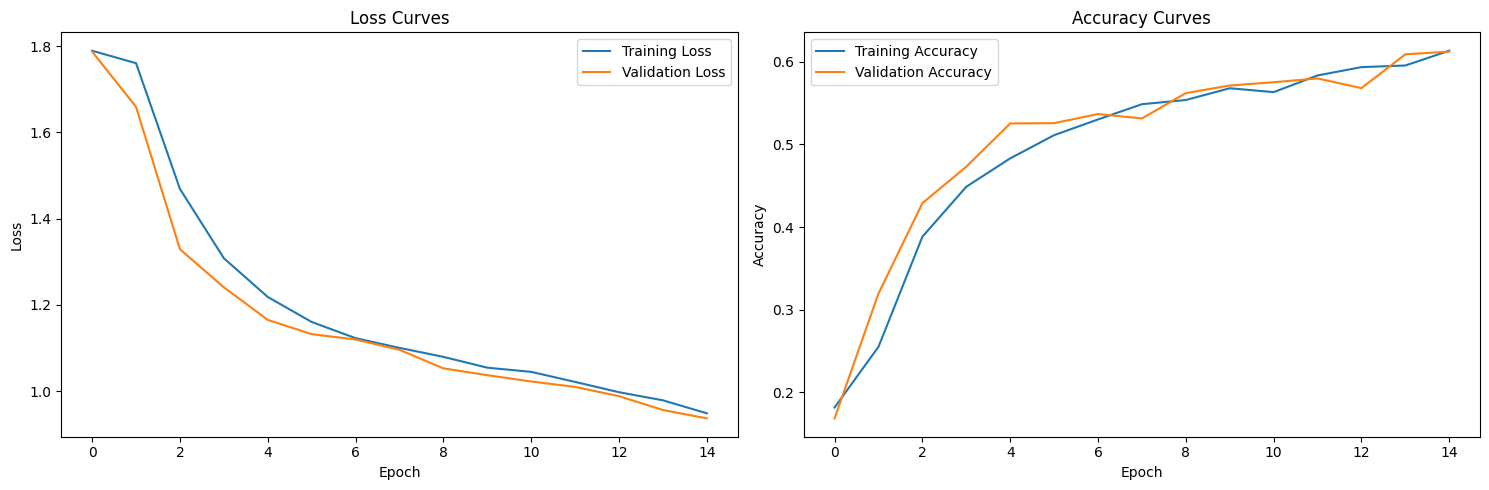

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Test Loss: 0.9265, Test Accuracy: 0.6153


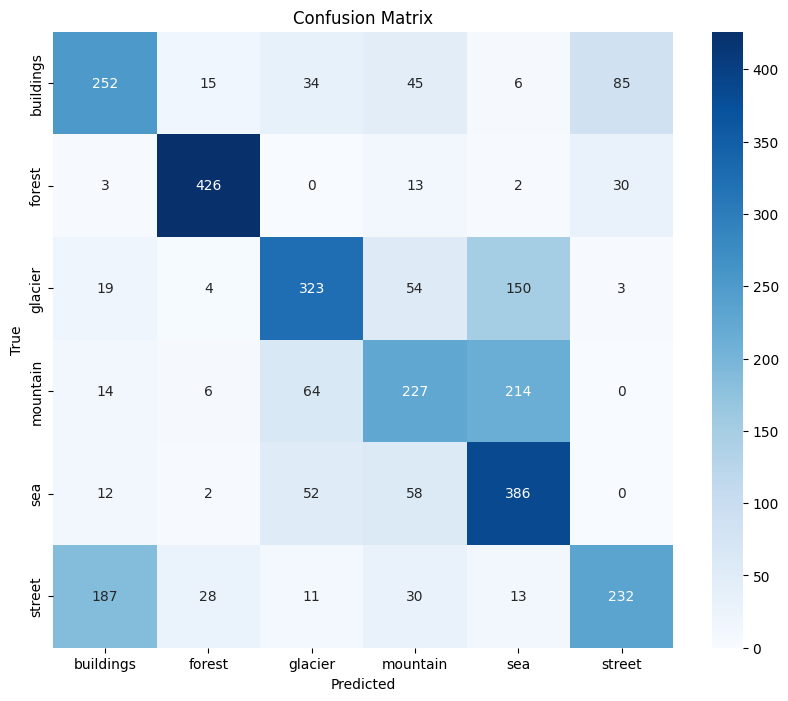

Classification Report:
              precision    recall  f1-score   support

   buildings       0.52      0.58      0.55       437
      forest       0.89      0.90      0.89       474
     glacier       0.67      0.58      0.62       553
    mountain       0.53      0.43      0.48       525
         sea       0.50      0.76      0.60       510
      street       0.66      0.46      0.55       501

    accuracy                           0.62      3000
   macro avg       0.63      0.62      0.61      3000
weighted avg       0.63      0.62      0.61      3000



In [15]:
# Define hyperparameters
num_epochs = 15
learning_rate = 1e-3

# Create model
lightweight_model2 = LightweightCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lightweight_model2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Train model
lightweight_model2, train_losses2, val_losses2, train_accs2, val_accs2 = train_model(
    lightweight_model2, train_loader, val_loader, optimizer, criterion, num_epochs=num_epochs
)

# Plot training curves
plot_training_curves(train_losses2, val_losses2, train_accs2, val_accs2)

# Evaluate on test set
test_loss2, test_acc2, all_preds2, all_labels2 = evaluate_model(lightweight_model2, test_loader, criterion)
print(f"Test Loss: {test_loss2:.4f}, Test Accuracy: {test_acc2:.4f}")

# Plot confusion matrix
plot_confusion_matrix(all_labels2, all_preds2, class_names)

## 9. Experiment 3: Deeper CNN with 0.0003 lr + Adam

Epoch 1/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.8553, Train Acc: 0.6796 - Val Loss: 0.6924, Val Acc: 0.7492
Saved model with validation accuracy: 0.7492


Epoch 2/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 2/15 - Train Loss: 0.6036, Train Acc: 0.7828 - Val Loss: 0.5337, Val Acc: 0.7959
Saved model with validation accuracy: 0.7959


Epoch 3/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.5307, Train Acc: 0.8098 - Val Loss: 0.5801, Val Acc: 0.7969
Saved model with validation accuracy: 0.7969


Epoch 4/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.4958, Train Acc: 0.8237 - Val Loss: 0.5615, Val Acc: 0.8033
Saved model with validation accuracy: 0.8033


Epoch 5/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 5/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
   Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0> 
 Traceback (most recent call last):
   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/p

Epoch 5/15 - Train Loss: 0.4444, Train Acc: 0.8392 - Val Loss: 0.5759, Val Acc: 0.7916


Epoch 6/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>Traceback (most recent call last):

  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

       if w.is_alive():  
   ^ ^^ ^ ^ ^ ^^ ^^^^^^^
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/pr

Epoch 6/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.4259, Train Acc: 0.8456 - Val Loss: 0.3890, Val Acc: 0.8621
Saved model with validation accuracy: 0.8621


Epoch 7/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.4004, Train Acc: 0.8559 - Val Loss: 0.4248, Val Acc: 0.8500


Epoch 8/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.3734, Train Acc: 0.8654 - Val Loss: 0.4341, Val Acc: 0.8514


Epoch 9/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.3615, Train Acc: 0.8706 - Val Loss: 0.3886, Val Acc: 0.8668
Saved model with validation accuracy: 0.8668


Epoch 10/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.3307, Train Acc: 0.8795 - Val Loss: 0.3918, Val Acc: 0.8603


Epoch 11/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>^
^Traceback (most recent call last):
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()

AssertionError  File

Epoch 11/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception ignored in: AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>can only test a child process

Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 11/15 - Train Loss: 0.3381, Train Acc: 0.8798 - Val Loss: 0.3870, Val Acc: 0.8607


Epoch 12/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>^^
Traceback (most recent call last):
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    self._shutdown_workers()^
^  File "/home/shinobi-owl/anaconda3

Epoch 12/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.3131, Train Acc: 0.8852 - Val Loss: 0.3881, Val Acc: 0.8628


Epoch 13/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.2958, Train Acc: 0.8939 - Val Loss: 0.3677, Val Acc: 0.8707
Saved model with validation accuracy: 0.8707


Epoch 14/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.2884, Train Acc: 0.8952 - Val Loss: 0.3522, Val Acc: 0.8771
Saved model with validation accuracy: 0.8771


Epoch 15/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.2704, Train Acc: 0.9019 - Val Loss: 0.4085, Val Acc: 0.8611


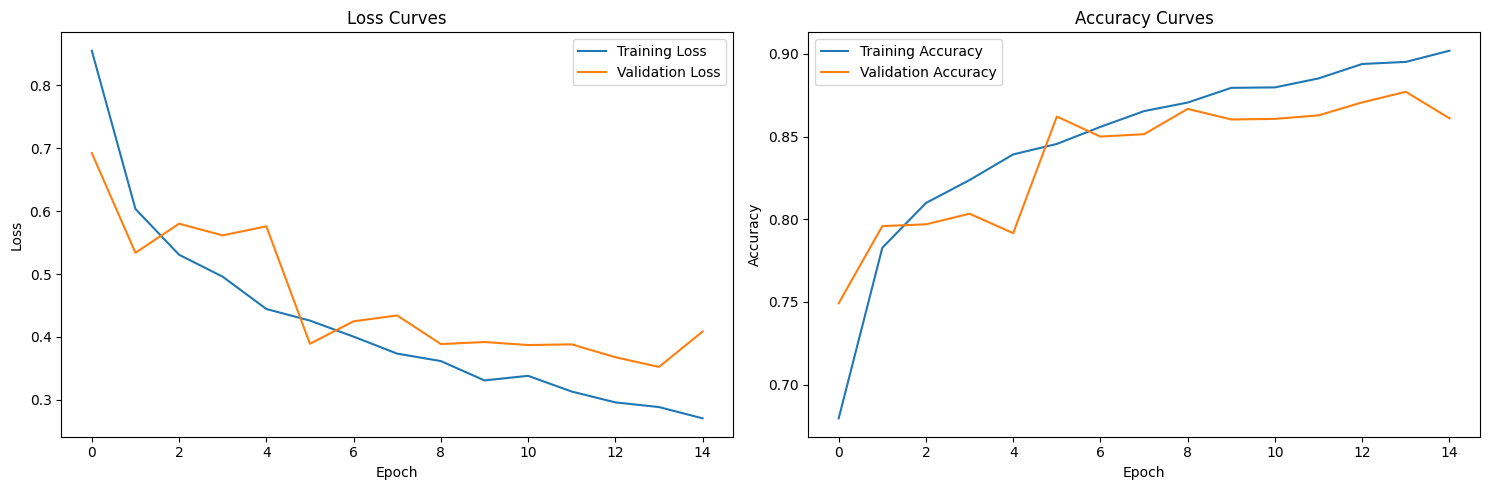

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Test Loss: 0.3704, Test Accuracy: 0.8700


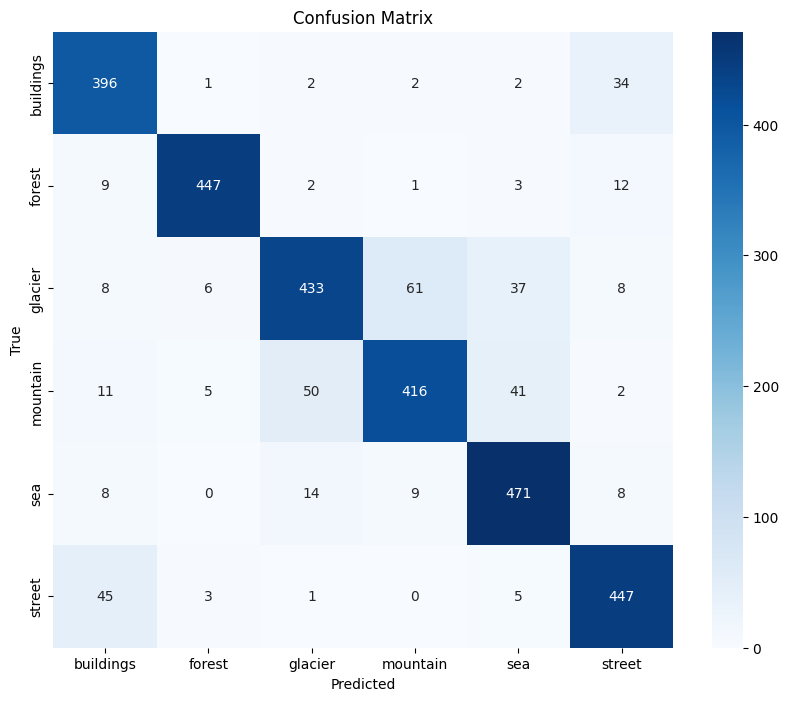

Classification Report:
              precision    recall  f1-score   support

   buildings       0.83      0.91      0.87       437
      forest       0.97      0.94      0.96       474
     glacier       0.86      0.78      0.82       553
    mountain       0.85      0.79      0.82       525
         sea       0.84      0.92      0.88       510
      street       0.87      0.89      0.88       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [16]:
# Define hyperparameters
num_epochs = 15
learning_rate = 3e-4  # Lower learning rate for deeper model

# Create model
deeper_model1 = deeper_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deeper_model1.parameters(), lr=learning_rate)

# Train model
deeper_model1, train_losses3, val_losses3, train_accs3, val_accs3 = train_model(
    deeper_model1, train_loader, val_loader, optimizer, criterion, num_epochs=num_epochs
)

# Plot training curves
plot_training_curves(train_losses3, val_losses3, train_accs3, val_accs3)

# Evaluate on test set
test_loss3, test_acc3, all_preds3, all_labels3 = evaluate_model(deeper_model1, test_loader, criterion)
print(f"Test Loss: {test_loss3:.4f}, Test Accuracy: {test_acc3:.4f}")

# Plot confusion matrix
plot_confusion_matrix(all_labels3, all_preds3, class_names)

## 10. Experiment 4: Deeper CNN with 0.001 lr + SGD

Epoch 1/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>^

AssertionErrorTraceback (most recent call last):
: can only test a child process  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__

   

Epoch 1/15 - Train Loss: 0.2433, Train Acc: 0.9120 - Val Loss: 0.3258, Val Acc: 0.8828
Saved model with validation accuracy: 0.8828


Epoch 2/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Exception ignored in: Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
    Traceback (most recent call last):
self._shutdown_workers()  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
        ^ ^ ^ ^^^^^^^^^^^^^^^^^^
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocess

Epoch 2/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.2197, Train Acc: 0.9221 - Val Loss: 0.4090, Val Acc: 0.8636


Epoch 3/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.2000, Train Acc: 0.9301 - Val Loss: 0.3421, Val Acc: 0.8814


Epoch 4/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.1940, Train Acc: 0.9305 - Val Loss: 0.3357, Val Acc: 0.8831
Saved model with validation accuracy: 0.8831


Epoch 5/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.1839, Train Acc: 0.9360 - Val Loss: 0.3272, Val Acc: 0.8864
Saved model with validation accuracy: 0.8864


Epoch 6/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.1693, Train Acc: 0.9390 - Val Loss: 0.3057, Val Acc: 0.8981
Saved model with validation accuracy: 0.8981


Epoch 7/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>^
^Traceback (most recent call last):
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/home/shinobi

Epoch 7/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 7/15 - Train Loss: 0.1761, Train Acc: 0.9354 - Val Loss: 0.3171, Val Acc: 0.8928


Epoch 8/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
Exception ignored in:   File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
    Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  
         ^ ^ ^ ^^^^^^^^^^^^^^^^^^
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocess

Epoch 8/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.1741, Train Acc: 0.9377 - Val Loss: 0.3160, Val Acc: 0.8935


Epoch 9/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.1690, Train Acc: 0.9401 - Val Loss: 0.3281, Val Acc: 0.8888


Epoch 10/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.1621, Train Acc: 0.9434 - Val Loss: 0.3110, Val Acc: 0.8938


Epoch 11/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.1621, Train Acc: 0.9422 - Val Loss: 0.3190, Val Acc: 0.8935


Epoch 12/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.1647, Train Acc: 0.9404 - Val Loss: 0.3044, Val Acc: 0.8949


Epoch 13/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0> 
 Traceback (most recent call last):
^^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^^^  File "/home/shinobi-owl/anaconda3/envs/se

Epoch 13/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   

Epoch 13/15 - Train Loss: 0.1559, Train Acc: 0.9439 - Val Loss: 0.3032, Val Acc: 0.8967


Epoch 14/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcafb948ae0>Traceback (most recent call last):

  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
           ^^ ^ ^^^^^^^^^^^^^^^^
^  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessin

Epoch 14/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.1586, Train Acc: 0.9434 - Val Loss: 0.3101, Val Acc: 0.8960


Epoch 15/15 [Train]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.1558, Train Acc: 0.9446 - Val Loss: 0.3075, Val Acc: 0.8960


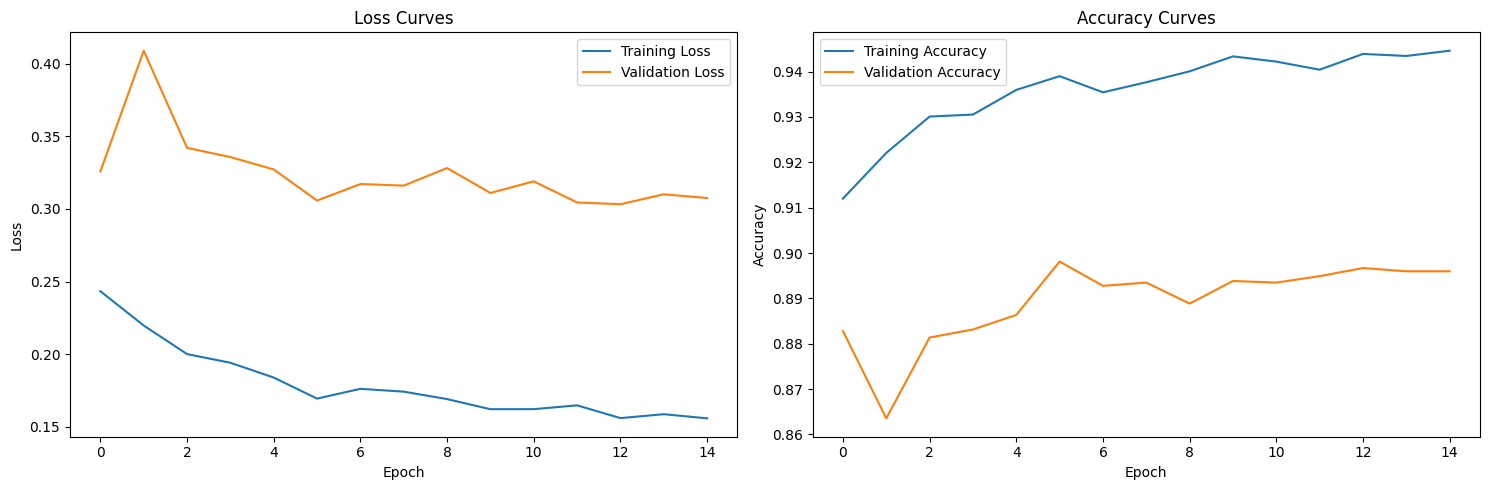

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Test Loss: 0.3069, Test Accuracy: 0.8950


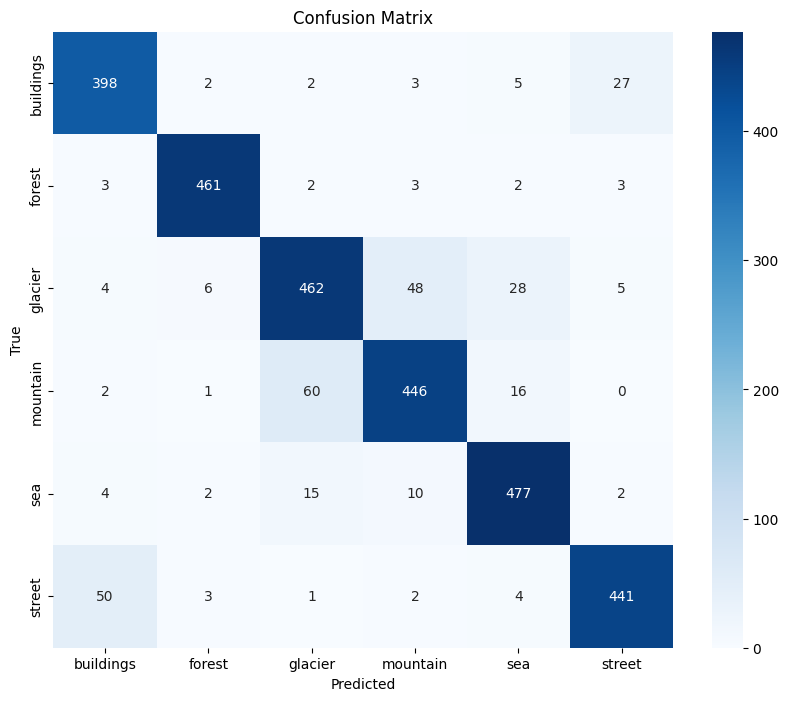

Classification Report:
              precision    recall  f1-score   support

   buildings       0.86      0.91      0.89       437
      forest       0.97      0.97      0.97       474
     glacier       0.85      0.84      0.84       553
    mountain       0.87      0.85      0.86       525
         sea       0.90      0.94      0.92       510
      street       0.92      0.88      0.90       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.89      3000



In [17]:
# Define hyperparameters
num_epochs = 15
learning_rate = 1e-3

# Create model
deeper_model2 = deeper_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(deeper_model2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Train model with learning rate scheduler
deeper_model2, train_losses4, val_losses4, train_accs4, val_accs4 = train_model(
    deeper_model2, train_loader, val_loader, optimizer, criterion, num_epochs=num_epochs, scheduler=scheduler
)

# Plot training curves
plot_training_curves(train_losses4, val_losses4, train_accs4, val_accs4)

# Evaluate on test set
test_loss4, test_acc4, all_preds4, all_labels4 = evaluate_model(deeper_model2, test_loader, criterion)
print(f"Test Loss: {test_loss4:.4f}, Test Accuracy: {test_acc4:.4f}")

# Plot confusion matrix
plot_confusion_matrix(all_labels4, all_preds4, class_names)

## 11. Visualize Examples of Correct and Incorrect Predictions

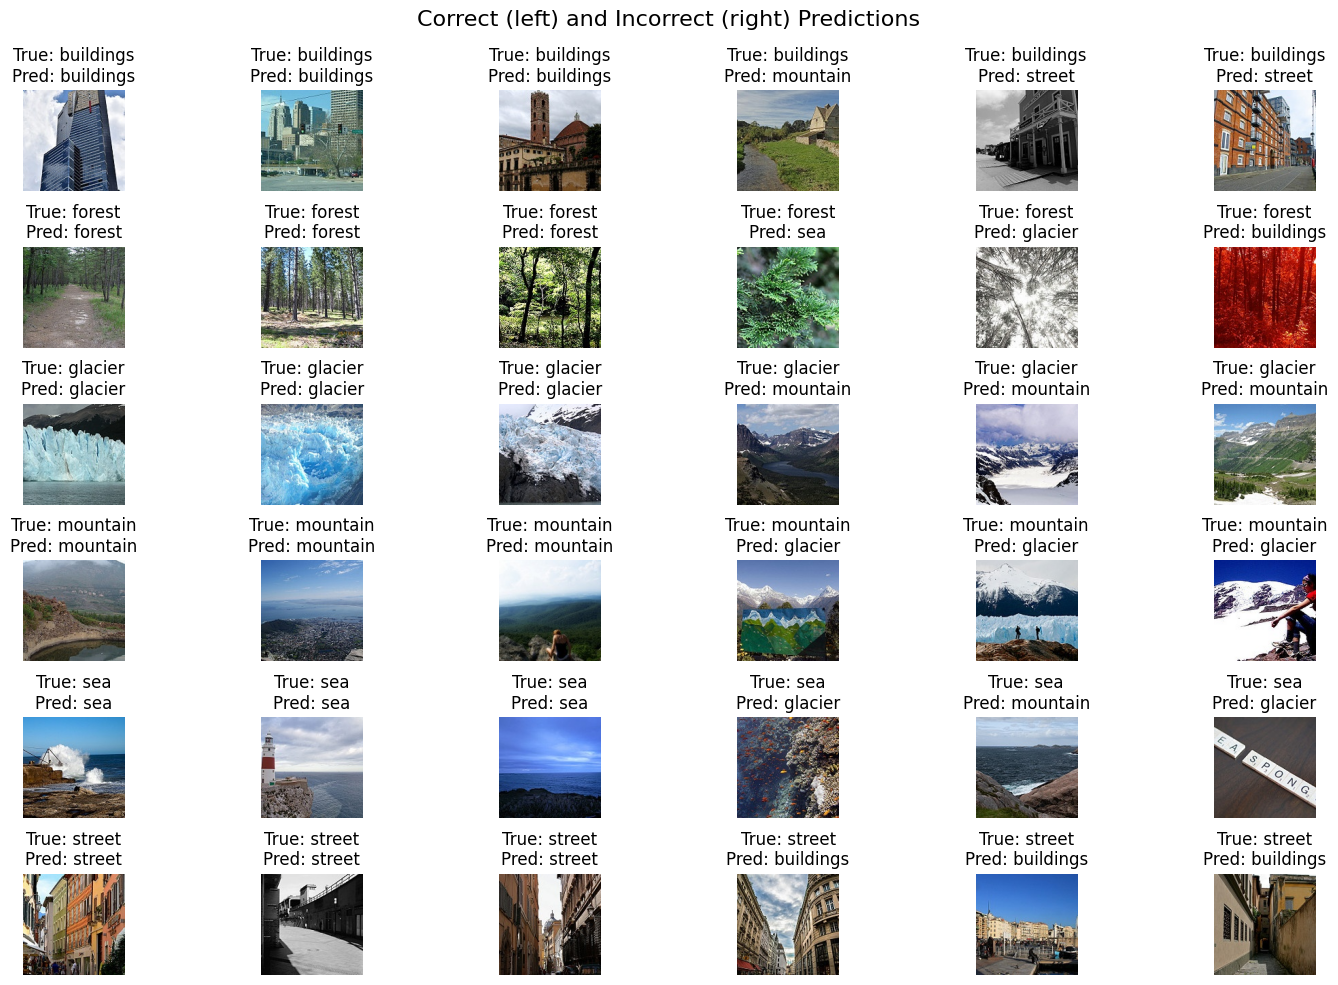

In [18]:
def visualize_predictions(model, data_loader, class_names, num_examples=10):
    model.eval()
    correct_examples = [[] for _ in range(len(class_names))]
    incorrect_examples = [[] for _ in range(len(class_names))]
    incorrect_pred_classes = [[] for _ in range(len(class_names))]
    
    # Get denormalization function
    mean = torch.tensor([0.485, 0.456, 0.406], device=device)
    std = torch.tensor([0.229, 0.224, 0.225], device=device)
    
    def denormalize(x):
        x = x.clone()
        x = x * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)
        return torch.clamp(x, 0, 1)
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Denormalize images
            inputs_denorm = denormalize(inputs)
            
            # Collect correct and incorrect examples
            for i in range(len(labels)):
                label = labels[i].item()
                pred = preds[i].item()
                img = inputs_denorm[i].cpu()
                
                if pred == label:
                    if len(correct_examples[label]) < num_examples:
                        correct_examples[label].append(img)
                else:
                    if len(incorrect_examples[label]) < num_examples:
                        incorrect_examples[label].append(img)
                        incorrect_pred_classes[label].append(pred)
            
            # Check if we have enough examples
            enough_examples = True
            for i in range(len(class_names)):
                if len(correct_examples[i]) < min(3, num_examples) or len(incorrect_examples[i]) < min(3, num_examples):
                    enough_examples = False
                    break
            
            if enough_examples:
                break
    
    # Visualize examples
    num_classes_to_show = min(6, len(class_names))  # Show at most 6 classes
    
    plt.figure(figsize=(15, 10))
    for i in range(num_classes_to_show):
        # Correct examples
        for j in range(min(3, len(correct_examples[i]))):
            plt.subplot(num_classes_to_show, 6, i*6 + j + 1)
            plt.imshow(correct_examples[i][j].permute(1, 2, 0))
            plt.title(f"True: {class_names[i]}\nPred: {class_names[i]}")
            plt.axis('off')
        
        # Incorrect examples
        for j in range(min(3, len(incorrect_examples[i]))):
            plt.subplot(num_classes_to_show, 6, i*6 + j + 4)
            plt.imshow(incorrect_examples[i][j].permute(1, 2, 0))
            pred_class = incorrect_pred_classes[i][j]
            plt.title(f"True: {class_names[i]}\nPred: {class_names[pred_class]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Correct (left) and Incorrect (right) Predictions", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Visualize predictions for the best performing model
best_model = deeper_model2  # Assuming this is the best model, replace if necessary
visualize_predictions(best_model, test_loader, class_names)

## 12. Compare All Models

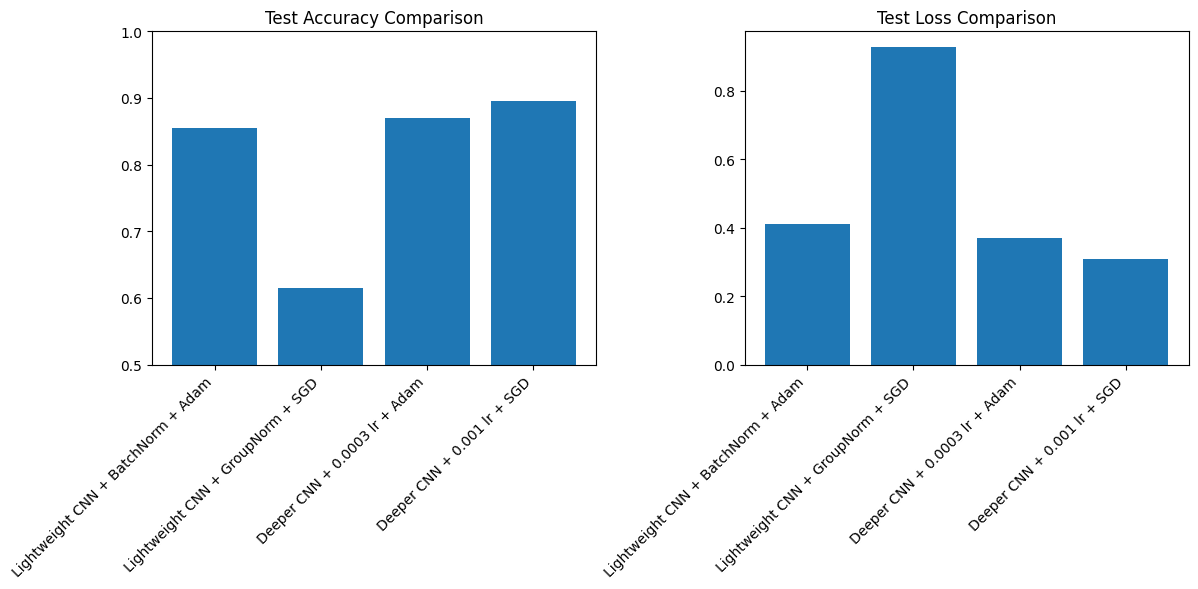

,Model,Parameters,Test Accuracy,Test Loss
0,Lightweight CNN + BatchNorm + Adam,"526,662",0.8543,0.4090
1,Lightweight CNN + GroupNorm + SGD,"526,662",0.6153,0.9265
2,Deeper CNN + 0.0003 lr + Adam,"11,179,590",0.8700,0.3704
3,Deeper CNN + 0.001 lr + SGD,"11,179,590",0.8950,0.3069


In [20]:
# Summarize model performances
models = [
    "Lightweight CNN + BatchNorm + Adam",
    "Lightweight CNN + GroupNorm + SGD",
    "Deeper CNN + 0.0003 lr + Adam",
    "Deeper CNN + 0.001 lr + SGD"
]

test_accuracies = [test_acc1, test_acc2, test_acc3, test_acc4]
test_losses = [test_loss1, test_loss2, test_loss3, test_loss4]

plt.figure(figsize=(12, 6))

# Plot test accuracies
plt.subplot(1, 2, 1)
plt.bar(models, test_accuracies)
plt.ylim(0.5, 1.0)  # Adjust as needed
plt.title('Test Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Plot test losses
plt.subplot(1, 2, 2)
plt.bar(models, test_losses)
plt.title('Test Loss Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Print model comparison table
comparison_data = {
    'Model': models,
    'Parameters': [
        f"{sum(p.numel() for p in lightweight_model1.parameters()):,}",
        f"{sum(p.numel() for p in lightweight_model2.parameters()):,}",
        f"{sum(p.numel() for p in deeper_model1.parameters()):,}",
        f"{sum(p.numel() for p in deeper_model2.parameters()):,}"
    ],
    'Test Accuracy': [f"{acc:.4f}" for acc in test_accuracies],
    'Test Loss': [f"{loss:.4f}" for loss in test_losses]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

## 13. Updated Conclusion and Discussion

In this notebook, we performed multi-class image classification on the Intel Image Classification dataset using PyTorch and CNNs of varying capacities. The experiments provided valuable insights into the impact of model architecture, normalization techniques, and optimization strategies. Here are the updated conclusions:

1. **Model Capacity**:
   - The deeper CNN model (~11M parameters) consistently outperformed the lightweight CNN model (~500K parameters) across all metrics.
   - The additional capacity in the deeper model allowed it to better capture complex features in the dataset, achieving the highest test accuracy of **89.5%**.

2. **Normalization Techniques**:
   - Batch Normalization outperformed Group Normalization in both lightweight and deeper models.
   - This result aligns with expectations, as Batch Normalization is more effective with larger batch sizes (32 in this case).

3. **Optimizers**:
   - The Adam optimizer demonstrated faster convergence and better performance compared to SGD in most cases.
   - However, SGD with momentum and a learning rate scheduler achieved the best overall performance when paired with the deeper model, highlighting the importance of proper learning rate scheduling.

4. **Challenging Cases**:
   - The confusion matrices revealed that visually similar categories, such as "glacier" and "mountain," were often misclassified.
   - Similarly, "buildings" and "street" were occasionally confused, which is reasonable given their overlapping visual features.

5. **Model Comparison**:
   - The deeper CNN with SGD and a learning rate of 0.001 achieved the best test accuracy (**89.5%**) and the lowest test loss (**0.307**).
   - The lightweight CNN with Batch Normalization and Adam achieved a respectable test accuracy of **85.4%**, demonstrating its effectiveness despite its smaller size.

6. **Potential Improvements**:
   - Incorporating transfer learning from pre-trained models (e.g., ImageNet) could further improve performance.
   - More aggressive data augmentation strategies could help the models generalize better.
   - Ensemble methods combining predictions from multiple models might boost accuracy.
   - Fine-tuning the learning rate schedule and experimenting with other optimizers could yield additional gains.

Overall, the deeper CNN with Batch Normalization and SGD optimizer emerged as the best-performing model, demonstrating the importance of model capacity, normalization, and optimization strategies in achieving high performance on image classification tasks.